In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import pickle
import estimator as e
import matplotlib.pyplot as plt

# Load data

In [125]:
with open("ecb.pkl" , "rb") as f:
    ecb = pickle.load(f)
    ecb.sort_index(inplace=True)
    
with open("fed.pkl" , "rb") as f:
    fed = pickle.load(f)
    fed.sort_index(inplace=True)

with open("data.pkl" , "rb") as f:
    data = pickle.load(f)
    data.sort_index(inplace=True)

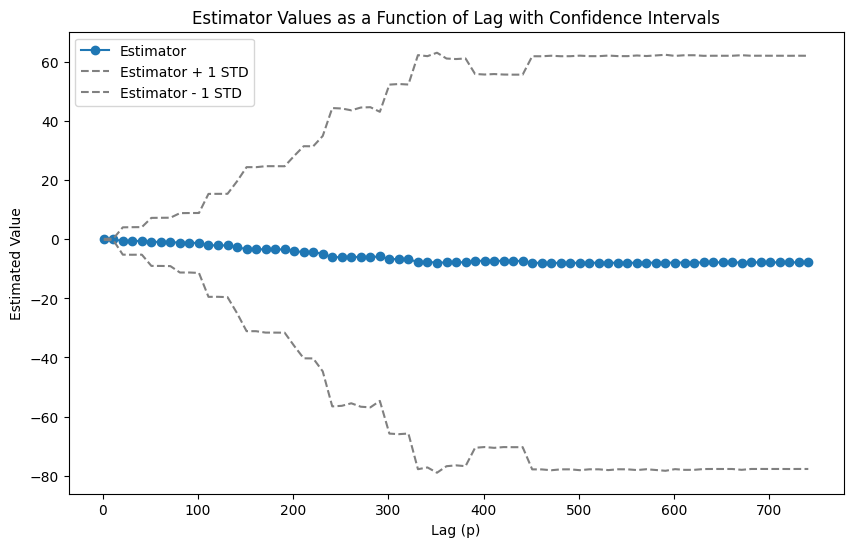

In [126]:
estimator= e.Estimator(W=fed, Y=data,treatment="Numeric Change", outcome="CPICYOY Index")
estimator.compute_estimator( p=10, h=5, w=25, w_prime=-25, min_obs=10)
estimator.plot_effect( h=15, w=75, w_prime=0, p_range=[k for k in range(1,750,10)], min_obs=10)

In [139]:
estimator.local_projection(p=200,min_obs=50, other_controls=["USURTOT Index","IP  CHNG Index"],lagW = [30], lagY=[0])

(0.0045904492715579765, 0.006690805449876386)

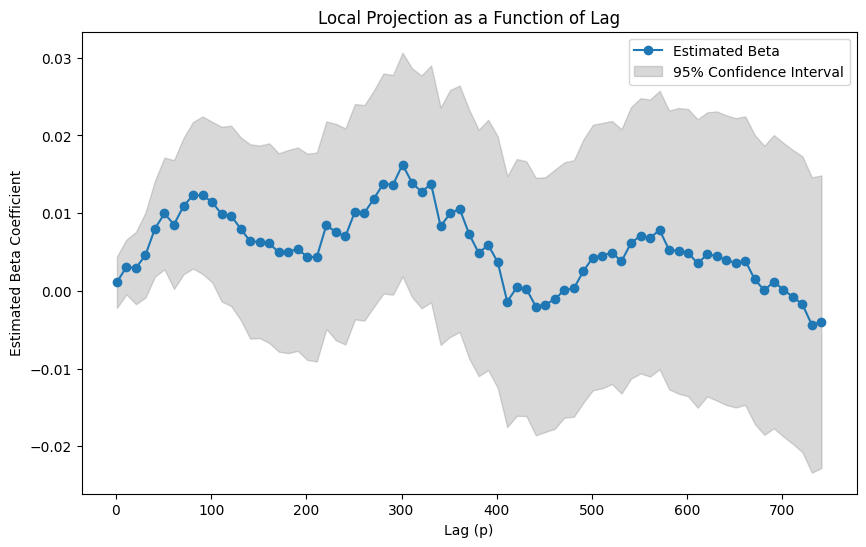

In [141]:
estimator.plot_local_projection(p_range=[k for k in range(1,750,10)],min_obs=50, other_controls=["USURTOT Index","IP  CHNG Index"],lagW = [30], lagY=[0])